<a href="https://colab.research.google.com/github/amilsiddik/Deep-Learning/blob/main/Deteksi_Hand_SignResNet50_New.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import cv2 as cv
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = "/content/drive/MyDrive/Penelitian/Deteksi hand sign/Dataset"
key_value= dict()
for i in os.listdir(path):
    key_value[i] = os.listdir(path+'/'+i)

In [4]:
df = []
for key in key_value.keys():
    for j in key_value[key]:
        df.append([key,path+'/'+key+'/'+j])
df1 = pd.DataFrame(df,columns=('label','path'))
df1

,label,path
0,6,/content/drive/MyDrive/Penelitian/Deteksi hand...
1,6,/content/drive/MyDrive/Penelitian/Deteksi hand...
2,6,/content/drive/MyDrive/Penelitian/Deteksi hand...
3,6,/content/drive/MyDrive/Penelitian/Deteksi hand...
4,6,/content/drive/MyDrive/Penelitian/Deteksi hand...
...,...,...
2057,7,/content/drive/MyDrive/Penelitian/Deteksi hand...
2058,7,/content/drive/MyDrive/Penelitian/Deteksi hand...
2059,7,/content/drive/MyDrive/Penelitian/Deteksi hand...
2060,7,/content/drive/MyDrive/Penelitian/Deteksi hand...


In [5]:
def readimg(path):
    img= cv.imread(path)
    img = cv.resize(img,(224,224))
    return img

In [6]:
import multiprocessing

# Create a Pool with 4 worker processes
with multiprocessing.Pool(4) as p:
    # Read in all of the images in parallel
    images = p.map(readimg, df1['path'])

In [7]:
images=np.array(images, dtype='float')
# label encoder from sklearn
le = preprocessing.LabelEncoder()
y_labels = le.fit_transform(df1['label'])

In [8]:
# to split the data into training and testing data
train_images,test_images,train_labels,test_labels = train_test_split(images,y_labels,test_size=0.25, random_state=42)

In [9]:
## implementing trensfer learning
base_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# freezing the base model so we donot have to train it again
base_model.trainable = False


model = keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(1024, activation='relu'),
  keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

94765736/94765736 [==============================] - 0s 0us/step


In [10]:
history = model.fit(train_images,train_labels, epochs=50, batch_size=32,validation_data=(test_images, test_labels))

Epoch 1/50
49/49 [==============================] - 23s 197ms/step - loss: 1.2018 - accuracy: 0.6339 - val_loss: 0.4547 - val_accuracy: 0.8585
Epoch 2/50
49/49 [==============================] - 7s 148ms/step - loss: 0.4149 - accuracy: 0.8642 - val_loss: 0.4317 - val_accuracy: 0.8314
Epoch 3/50
49/49 [==============================] - 7s 146ms/step - loss: 0.2192 - accuracy: 0.9276 - val_loss: 0.2548 - val_accuracy: 0.9050
Epoch 4/50
49/49 [==============================] - 6s 126ms/step - loss: 0.1751 - accuracy: 0.9457 - val_loss: 0.4343 - val_accuracy: 0.8391
Epoch 5/50
49/49 [==============================] - 7s 146ms/step - loss: 0.1520 - accuracy: 0.9625 - val_loss: 0.2308 - val_accuracy: 0.9225
Epoch 6/50
49/49 [==============================] - 7s 151ms/step - loss: 0.0963 - accuracy: 0.9774 - val_loss: 0.2308 - val_accuracy: 0.9302
Epoch 7/50
49/49 [==============================] - 6s 124ms/step - loss: 0.0765 - accuracy: 0.9832 - val_loss: 0.2216 - val_accuracy: 0.9283
Epoch

In [11]:
from sklearn.metrics import accuracy_score

# Make predictions on the test data
predictions = model.predict(test_images)

# Convert the predictions to the class labels
predicted_labels = np.argmax(predictions, axis=1)

# Compute the accuracy score
accuracy = accuracy_score(test_labels, predicted_labels)

print('Accuracy:', accuracy)

17/17 [==============================] - 3s 93ms/step
Accuracy: 0.9457364341085271


In [12]:
from sklearn.metrics import precision_score

precision = precision_score(test_labels, predicted_labels, average='macro')

print('Precision:', precision)

Precision: 0.9475348862584339


In [13]:
from sklearn.metrics import recall_score

recall= recall_score(test_labels, predicted_labels, average='macro')

print('Recall:', recall)

Recall: 0.949592689873232


In [14]:
from sklearn.metrics import f1_score

f1= f1_score(test_labels, predicted_labels, average='macro')

print('F1-Score:', f1)

F1-Score: 0.94781451812493


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)

Text(0.5, 1.0, 'Accuracy Vs Epoch')

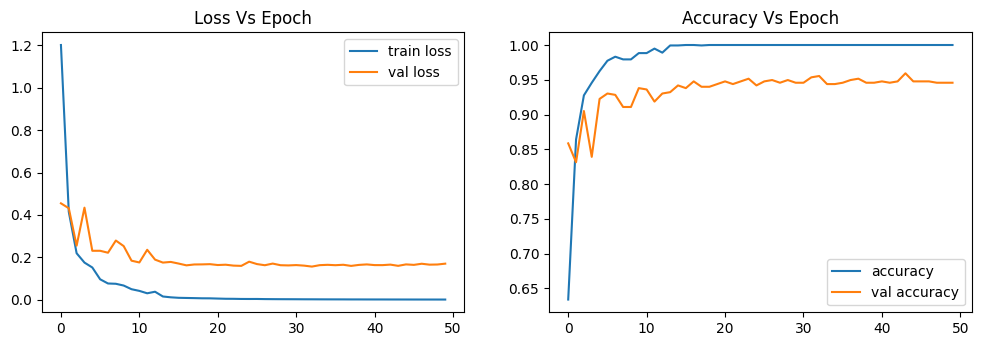

In [15]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss Vs Epoch')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.title('Accuracy Vs Epoch')

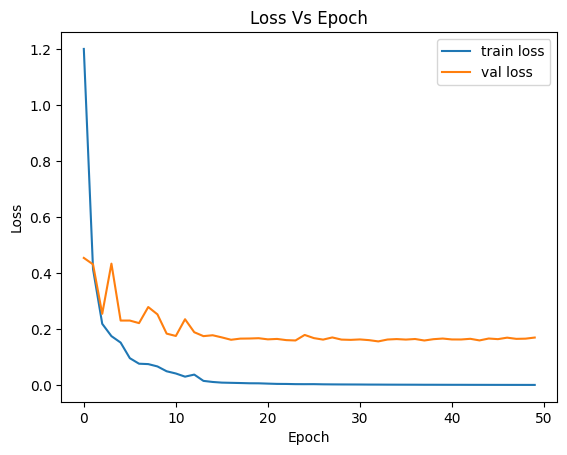

In [16]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss Vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

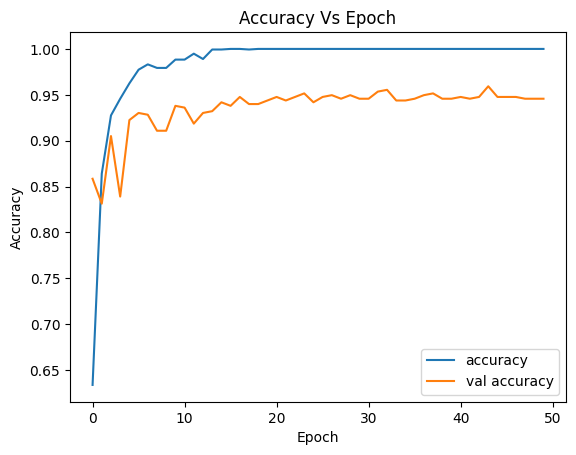

In [17]:
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.title('Accuracy Vs Epoch')
plt.show()

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 10)                10250     
                                                                 
Total params: 25,696,138
Trainable params: 2,108,426
Non-trainable params: 23,587,712
_________________________________________________________________


In [19]:
from sklearn.metrics import classification_report
pred = model.predict(test_images, verbose=1)
model_predicted = np.argmax(pred, axis = 1)

File=[]
for file in os.listdir(path):
    File+=[file]
print(File)
#print(classification_report(test_labels.argmax(axis=1), model_predicted, target_names=File))

17/17 [==============================] - 2s 95ms/step
['6', '8', '3', '4', '0', '5', '1', '9', '2', '7']


In [ ]:
test_images[1]
#Y_pred = model.predict(test_images[1])

array([[[122., 123., 127.],
        [121., 122., 126.],
        [121., 122., 126.],
        ...,
        [123., 121., 121.],
        [126., 123., 125.],
        [125., 123., 123.]],

       [[121., 122., 126.],
        [123., 124., 128.],
        [123., 124., 128.],
        ...,
        [125., 121., 122.],
        [123., 120., 122.],
        [123., 121., 121.]],

       [[120., 121., 125.],
        [114., 115., 119.],
        [124., 125., 129.],
        ...,
        [128., 123., 124.],
        [124., 122., 122.],
        [130., 125., 126.]],

       ...,

       [[125., 126., 130.],
        [124., 127., 131.],
        [123., 126., 130.],
        ...,
        [122., 123., 127.],
        [119., 121., 122.],
        [119., 121., 122.]],

       [[124., 127., 131.],
        [124., 128., 129.],
        [126., 129., 133.],
        ...,
        [122., 124., 125.],
        [123., 125., 126.],
        [122., 124., 125.]],

       [[122., 125., 129.],
        [122., 127., 130.],
        [125., 1

In [ ]:
test_images

array([[[[128., 123., 124.],
         [128., 123., 124.],
         [129., 123., 124.],
         ...,
         [114., 107., 107.],
         [114., 106., 106.],
         [114., 106., 106.]],

        [[128., 123., 124.],
         [128., 123., 124.],
         [129., 124., 125.],
         ...,
         [115., 107., 107.],
         [114., 106., 106.],
         [114., 106., 106.]],

        [[128., 123., 125.],
         [129., 124., 125.],
         [129., 124., 126.],
         ...,
         [115., 107., 107.],
         [115., 107., 107.],
         [115., 106., 106.]],

        ...,

        [[112., 110., 110.],
         [112., 110., 110.],
         [113., 111., 111.],
         ...,
         [ 92.,  90.,  90.],
         [ 92.,  90.,  90.],
         [ 92.,  90.,  90.]],

        [[111., 109., 109.],
         [111., 109., 109.],
         [112., 110., 110.],
         ...,
         [ 91.,  88.,  88.],
         [ 91.,  88.,  88.],
         [ 91.,  88.,  88.]],

        [[111., 109., 109.],
       

17/17 [==============================] - 1s 91ms/step


Text(0.5, 1.0, 'Confusion Matrix')

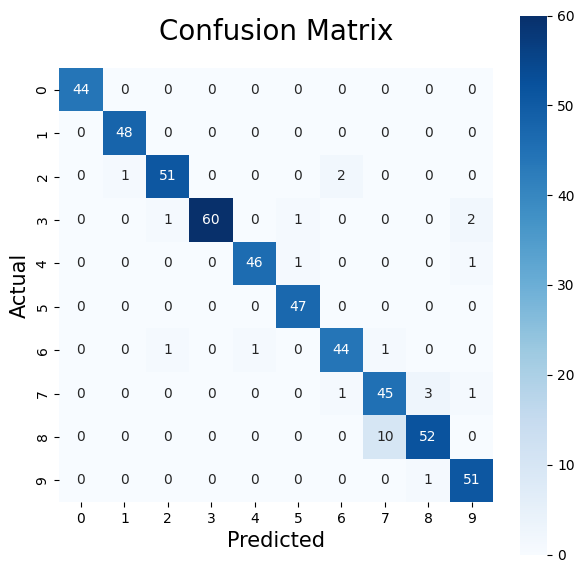

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Menampilkan Confusion Matrix
numer_type = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
Y_pred = model.predict(test_images)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = test_labels

fig, ax = plt.subplots(figsize=(7,7))
cm = confusion_matrix(Y_true, Y_pred)
#plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, 
                 square=True, xticklabels=numer_type, 
                 yticklabels=numer_type, ax=ax)
ax.set_ylabel('Actual', fontsize=15)
ax.set_xlabel('Predicted', fontsize=15)
ax.set_title('Confusion Matrix', fontsize=20, pad=20)

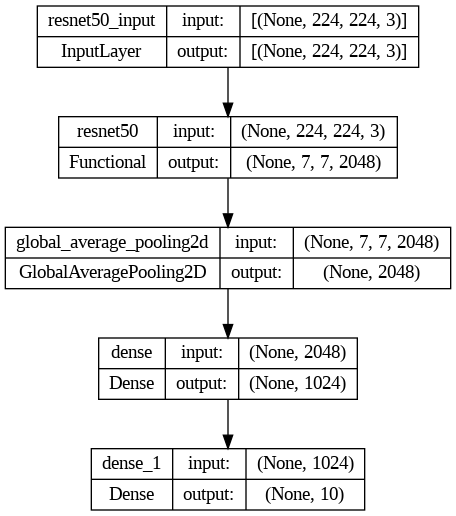

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True)